# <code style="color:Crimson">3. Feature Engineering</code>

#### Let's import all the libraries needed for feature engineering.

In [1]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns

# (Optional) Avoid FutureWarning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## <span style="color:RoyalBlue">1. Leverage Domain Knowledge</span>

#### Next, read in the dataset.
* The file name is <code style="color:crimson">'cleaned_df.csv'</code> 

In [2]:
df = pd.read_csv('cleaned_df.csv')

In [3]:
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,...,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,Missing,0.0,...,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,Brick,Composition Shingle,1.0,...,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,Wood Siding,Missing,0.0,...,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,Wood Siding,Missing,0.0,...,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,Brick,Missing,0.0,...,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002


**Example: 2 Beds & 2 Baths**

For example, let's say that homes with 2 bedrooms and 2 bathrooms are popular for investors. We suspect these types of properties command premium prices.

Sure, the number of bedrooms and the number of bathrooms are both existing features in your dataset. However, they do not specifically isolate this property type. Therefore, to isolate them, you could create an indicator variable just for properties with 2 beds and 2 baths.

In [4]:
#select houses with 2 beds and 2 baths
((df.beds == 2) & (df.baths == 2)).astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
1877    0
1878    0
1879    0
1880    0
1881    0
Length: 1882, dtype: int64

In [5]:
#Create a new feature 'two_and_two'
df['two_and_two'] = ((df.beds == 2) & (df.baths == 2)).astype(int)

In [6]:
#verify the new feature
df.two_and_two.unique()

array([0, 1])

**Example: Housing Market Recession**

Because we're modeling housing prices in the United States, it's important to consider the housing market recession. According to data from Zillow, the lowest housing prices were from 2010 to end of 2013 (country-wide).

Let's create a new feature called <code style="color:crimson">'during_recession'</code>to indicate if a transaction falls between 2010 and 2013

In [7]:
#houses sold between 2010 and 2013
df['during_recession']=((df.tx_year >=2010) & (df.tx_year <=2013)).astype(int)

#or use df.tx_year.between(2010, 2013).astype(int)

## <span style="color:RoyalBlue">2. Create Interaction Features</span>

**Interaction features** are operations between two or more other features.

In some contexts, interaction features can be products, sums, or differences between two features.

**Example: Property Age**

In our dataset, we know the transaction year and the year the property was built in. However, just knowing the year built alone is not so useful, unless we suspect that all the houses built in a particular year were defective or subject to some other freak incident.


Instead, the more useful piece of information these two features provide is the age of the property at the time of the transaction. So let's create a <code style="color:steelblue">'property_age'</code> feature.

In [8]:
#create a new feature with property age
df['property_age'] = df.tx_year - df.year_built

In [9]:
# Sanity check - Property asge should not be less than 0
print( df.property_age.min() )

-8


#### We have a min property age that is negative. Let's investigate. Let's print the number of observations with <code style="color:steelblue">'property_age'</code> less than 0.

In [10]:
# Number of observations with 'property_age' < 0
print( sum(df.property_age < 0) )

19



We need to discard these observations

In [11]:
# Remove observations where property_age is less than 0
df= df[df.property_age >= 0]

In [12]:
#sanity check
len(df[df.property_age <0])

0

**Example: School Score**

Create a new feature called <code style="color:steelblue">'school_score'</code>that is the product of <code style="color:steelblue">'num_schools'</code> and <code style="color:steelblue">'median_school'</code>.

In [13]:
# Create a school score feature that num_schools * median_school
df['school_score'] = df.num_schools * df.median_school

In [14]:
#Sanity check
df.school_score.describe()

count    1863.000000
mean       17.982823
std         6.465535
min         3.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        30.000000
Name: school_score, dtype: float64

## <span style="color:RoyalBlue">3. Group Sparse Classes</span>

Sparse classes are classes in categorical features that have very few total observations. We'll consider grouping sparse classes in our categorical features.

**A. Let's check the <code style="color:steelblue">'exterior_walls'</code> feature.**

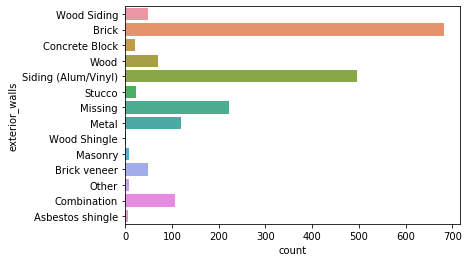

In [15]:
# Bar plot for exterior_walls
sns.countplot(y='exterior_walls', data=df)
plt.show()

As we can see, we have severals classes with very few observations. 

**We can start by grouping classes that are similar.**
* For example, we can group <code style="color:crimson">'Wood Siding'</code> , <code style="color:crimson">'Wood Shingle'</code> and <code style="color:crimson">'Wood'</code> together and call them <code style="color:crimson">'Wood'</code>

In [16]:
# Group 'Wood Siding' and 'Wood Shingle' with 'Wood'
df.exterior_walls.replace(['Wood Siding', 'Wood Shingle'], 'Wood', inplace=True)

Next, we can group remaining sparse classes into a single <code style="color:crimson">'Other'</code>class.

Let's label<br>
<code style="color:crimson">'Stucco'</code><br>
<code style="color:crimson">'Other'</code><br>
<code style="color:crimson">'Asbestos shingle'</code><br>
<code style="color:crimson">'Concrete Block'</code><br>
<code style="color:crimson">'Masonry'</code><br>

as <code style="color:crimson">'Other'</code>

In [17]:
df.exterior_walls.replace(['Stucco','Asbestos shingle','Concrete Block','Masonry','Concrete','Block'], 'Other', inplace=True)

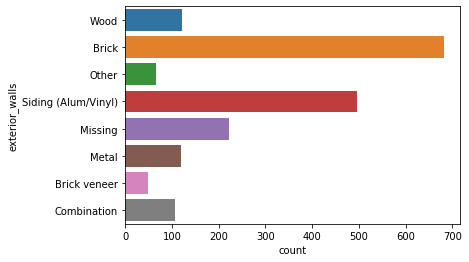

In [18]:
#Sanity check - Bar plot for exterior_walls
sns.countplot(y='exterior_walls', data=df)
plt.show()

**B. Let's check the <code style="color:steelblue">'roof'</code> feature.**

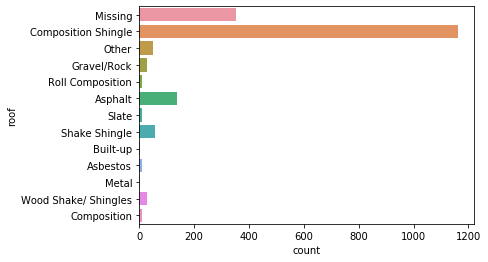

In [19]:
# Bar plot for roof
sns.countplot(y='roof', data=df)
plt.show()

As we can see, we have severals classes with very few observations. 

**We can start by grouping classes that are similar.**

* For example, we can group <code style="color:crimson">'Composition'</code> and <code style="color:crimson">'Wood Shake/ Shingles'</code> into the <code style="color:crimson">'Composition Shingle'</code> class.

In [20]:
# Group 'Composition' and 'Wood Shake/ Shingles' into 'Composition Shingle'
df.roof.replace(['Composition', 'Wood Shake/ Shingles'],
                'Composition Shingle', inplace=True)

Next, we can group remaining sparse classes into a single <code style="color:crimson">'Other'</code> class.

Let's label<br>
<code style="color:crimson">'Other'</code><br>
<code style="color:crimson">'Gravel/Rock'</code><br>
<code style="color:crimson">'Roll Composition'</code><br>
<code style="color:crimson">'Slate'</code><br>
<code style="color:crimson">'Built-up'</code><br>
<code style="color:crimson">'Asbestos'</code><br>
<code style="color:crimson">'Metal'</code> 

as <code style="color:crimson">'Other'</code>.

In [21]:
# List of classes to group
df.roof.replace(['Gravel/Rock','Roll Composition','Slate','Built-up','Asbestos','Metal'],'Other',inplace=True)

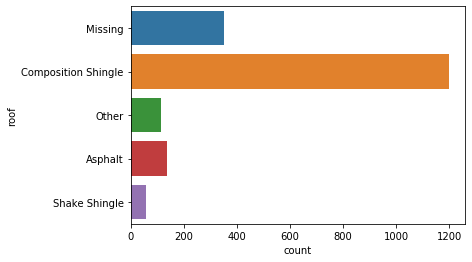

In [22]:
#Sanity check - Bar plot for roof
sns.countplot(y='roof',data=df)
plt.show()

## <span style="color:RoyalBlue">4. Prepare Analytical Base Table</span>


**Analytical Base Table (ABT)** is the table that has already been cleaned and augmented through feature engineering, to perform analyses and is used for building the models.

**Dummy Variables**

Python machine learning algorithms cannot handle categorical features directly. Specifically, they cannot handle text data. Therefore, we need to create what are called dummy variables for our categorical features.

For example, for the <code style="color:steelblue">'exterior_walls'</code> feature (after grouping sparse classes), we're left with 8 unique classes and right now they are encoded as text values in a single feature column:

In [23]:
#Display unique classes
print( df.exterior_walls.unique() )

['Wood' 'Brick' 'Other' 'Siding (Alum/Vinyl)' 'Missing' 'Metal'
 'Brick veneer' 'Combination']


### One-Hot encoding

For <code style="color:steelblue">'exterior_walls'</code>, we would create 8 new dummy variables, one for each of its unique classes. So if an observation had exterior walls made of 'Brick', The new <code style="color:steelblue">'exterior_walls_Brick'</code> feature will be  **1**, and others will be **0**

Similarly for <code style="color:steelblue">'roof'</code> and <code style="color:steelblue">'property_type'</code>

#### Create dummy variables for all of categorical features at once and then save the new dataframe to a new object called abt

In [24]:
# Get dummy variables and display first 5 observations
abt = pd.get_dummies(df, columns=['roof','exterior_walls','property_type'])

In [25]:
abt.shape

(1863, 42)

Finally, let's remove unused or redundant features from our dataset. **Redundant features** would typically be those that have been replaced by other features. For example, since we used <code style="color:steelblue">'tx_year'</code> and <code style="color:steelblue">'year_built'</code> to create the <code style="color:steelblue">'property_age'</code> feature, we might consider removing them. 



#### Let's remove <code style="color:steelblue">'tx_year'</code> and <code style="color:steelblue">'year_built'</code> using Pandas's <code style="color:steelblue">.drop()</code> function.
* Remember that we have to set <code style="color:steelblue">axis=1</code> because we are dropping columns.
* Remember to do it 'inplace' as well.

In [26]:
abt.drop(['tx_year','year_built'], axis=1,inplace=True)

#### Save the abt as <code style="color:steelblue">'analytical_base_table.csv'</code>.

In [27]:
abt.to_csv('analytical_base_table.csv',index=None)

* Now we can use <code style="color:steelblue">'analytical_base_table.csv'</code> in all the future modules.